# Single time step prediction
## — with single input 

In [82]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from darts.datasets import EnergyDataset
from darts.dataprocessing.transformers import MissingValuesFiller
import numpy as np

from ontime.module import preprocessing

In [83]:
input_length = 10
target_length = 3
nb_neurons_hidden_layer = 8
shift_between_batches = 3
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
## Load data

In [84]:
energy_ts = EnergyDataset().load()
energy_ts = energy_ts.astype(np.float32)
single_ts = energy_ts.univariate_component(0)

---
## Preprocessing

In [85]:
# Fill missing values
transformer = MissingValuesFiller()
single_ts = transformer.transform(single_ts)

# Normalize
single_ts = preprocessing.common.normalize(single_ts)

# Train test split
train, test = preprocessing.common.train_test_split(single_ts, train_split=0.8)

# Split in vectors of length n
train_list = preprocessing.common.split_by_length(train, length=input_length + target_length, shift=shift_between_batches)
test_list = preprocessing.common.split_by_length(test, length=input_length + target_length, shift=shift_between_batches)

# Split each vector in input and target
X_train, y_train = preprocessing.common.split_inputs_from_targets(train_list, input_length=input_length,
                                                                  target_length=target_length)
X_test, y_test = preprocessing.common.split_inputs_from_targets(test_list, input_length=input_length,
                                                                target_length=target_length)

# Convert to Numpy
X_train = preprocessing.common.timeseries_list_to_numpy(X_train)
y_train = preprocessing.common.timeseries_list_to_numpy(y_train)
X_test = preprocessing.common.timeseries_list_to_numpy(X_test)
y_test = preprocessing.common.timeseries_list_to_numpy(y_test)

In [86]:
X_train = np.squeeze(X_train, axis=-1)
y_train = np.squeeze(y_train, axis=-1)
X_test = np.squeeze(X_test, axis=-1)
y_test = np.squeeze(y_test, axis=-1)

In [87]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9346, 10)
(9346, 3)
(2334, 10)
(2334, 3)


---
## Modelling

In [88]:
# Convert X_train and y_train to PyTorch tensors if not already
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).float().to(device)

class ModelDataset(Dataset): 
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = ModelDataset(X_train_tensor, y_train_tensor)
data_loader = DataLoader(ds, batch_size=input_length, shuffle=True)

In [89]:
item = iter(data_loader)
next(item)

[tensor([[0.9105, 0.9172, 0.9679, 0.9595, 0.9628, 0.9747, 0.9696, 0.9696, 0.9713,
          0.9628],
         [0.5794, 0.5743, 0.5828, 0.5811, 0.5760, 0.5794, 0.5828, 0.5845, 0.5811,
          0.5726],
         [0.6216, 0.6385, 0.6520, 0.6233, 0.6334, 0.6233, 0.6199, 0.6503, 0.6571,
          0.6622],
         [0.6351, 0.6368, 0.6351, 0.6334, 0.6301, 0.6334, 0.6385, 0.6402, 0.6368,
          0.6453],
         [0.5490, 0.5321, 0.5422, 0.5473, 0.5490, 0.5541, 0.5591, 0.5574, 0.5490,
          0.5507],
         [0.5693, 0.5642, 0.5574, 0.5557, 0.5541, 0.5591, 0.6250, 0.6216, 0.6149,
          0.6115],
         [0.7230, 0.7568, 0.7736, 0.7770, 0.7686, 0.7618, 0.7517, 0.7551, 0.7534,
          0.7162],
         [0.5946, 0.6014, 0.6047, 0.5997, 0.5946, 0.5743, 0.5726, 0.5794, 0.5828,
          0.5861],
         [0.7973, 0.8007, 0.8024, 0.7973, 0.7618, 0.6824, 0.6892, 0.6909, 0.6892,
          0.6841],
         [0.8328, 0.8345, 0.8429, 0.8463, 0.8412, 0.8193, 0.7500, 0.7314, 0.7247,
         

In [90]:
model = nn.Sequential(
    nn.Linear(input_length, nb_neurons_hidden_layer),
    nn.ReLU(),
    nn.Linear(nb_neurons_hidden_layer, target_length),
).to(device)

# Define the loss function and optimizer
loss = nn.MSELoss()

from torch.optim import SGD
import time

optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

losses = []
start = time.time()
for epoch in range(num_epochs):
    for X, y in data_loader:
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(X)
        # Compute Loss
        l = loss(y_pred, y)
        # Backward pass
        l.backward()
        # Update weights
        optimizer.step()
        # Reset the gradients
        optimizer.zero_grad()
        losses.append(l.item())
    print(f'Epoch {epoch}/{num_epochs} - Loss: {l.item():.4f}')
end = time.time()
print(f'Training time: {end - start}s')

Epoch 0/5 - Loss: 0.0002
Epoch 1/5 - Loss: 0.0011
Epoch 2/5 - Loss: 0.0018
Epoch 3/5 - Loss: 0.0006
Epoch 4/5 - Loss: 0.0002
Training time: 2.7385408878326416s


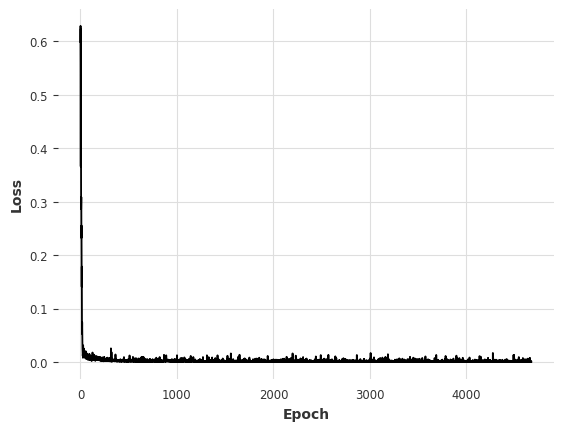

In [91]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Evaluate 

In [92]:
# Convert X_val and y_val to PyTorch tensors if not already
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Set the model to evaluation mode
model.eval()
criterion = nn.MSELoss()
# Forward pass on the validation set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

print(f'Validation Loss: {test_loss.item():.4f}')


Validation Loss: 0.0011


---
## Predict

In [93]:
print(f'Number of prediction samples: {target_length}')
prediction = model(X_test_tensor)
print(f'Actual prediction length {len(prediction[0])}')

if target_length != len(prediction[0]):
    raise ValueError('Prediction length is not equal to target length')

Number of prediction samples: 3
Actual prediction length 3


In [94]:
# Forward pass on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)

# Convert the tensor results back to a NumPy array
predicted_values = test_outputs.numpy()

In [95]:
print(f'Predicted values shape: {predicted_values.shape}')
print(f'Actual values shape: {y_test.shape}')
print(f'Single_ts shape: {len(single_ts)}')

Predicted values shape: (2334, 3)
Actual values shape: (2334, 3)
Single_ts shape: 35064


---
## Plot results

Plot results for each possible target. We are predicting that why we have multiple graphs.

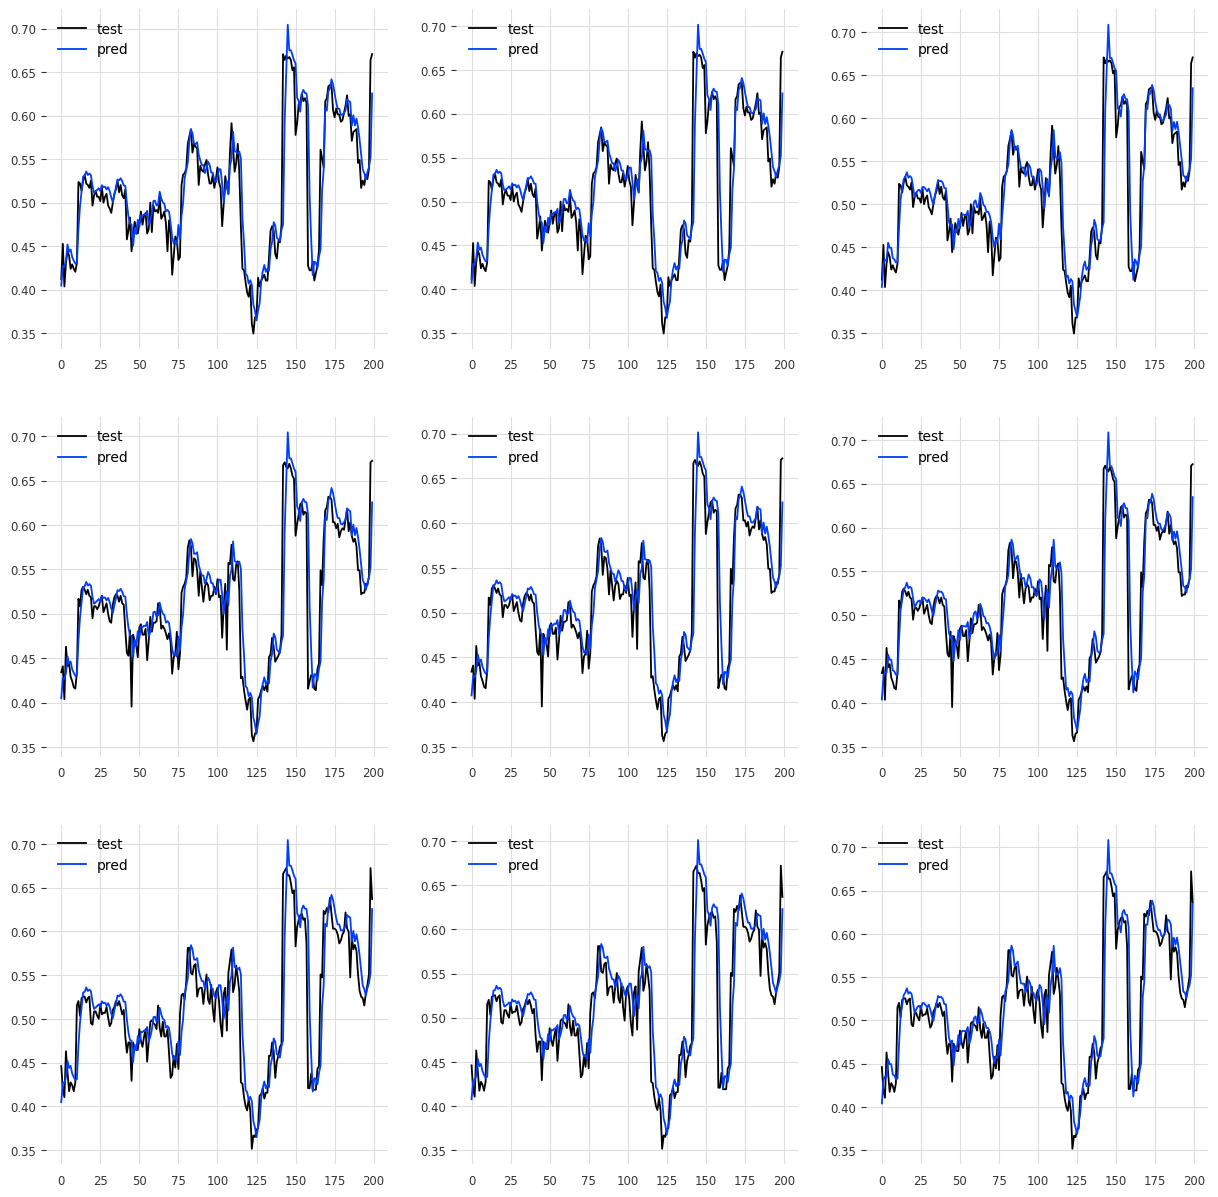

In [212]:
import pandas as pd
import matplotlib.pyplot as plt

start = 0
width = 200

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Loop through the subplots and plot the data
for i in range(3):
    for j in range(3):
        ax = axs[i, j]
        pd.DataFrame(y_test[:, i].squeeze()[start:start + width]).plot(ax=ax)
        pd.DataFrame(predicted_values[:, j].squeeze()[start:start + width]).plot(ax=ax)
        ax.legend(['test', 'pred'])

In [210]:
import pandas as pd
import numpy as np

df_copy = predicted_values.copy()
df_copy = pd.DataFrame(df_copy)

num_steps = 3

periods = np.arange(0, num_steps, 1)

i = 0 
for period in periods:
    df_copy.iloc[:, i] = df_copy.iloc[:, i].shift(period)
    i += 1

df_copy['mean'] = df_copy.mean(axis=1)
df_copy = df_copy.dropna()
df_copy = df_copy.reset_index(drop=True)
df_copy

,0,1,2,mean
0,0.426501,0.429127,0.403890,0.419839
1,0.433202,0.427620,0.430628,0.430483
2,0.451891,0.435215,0.435031,0.440712
3,0.443826,0.453314,0.434438,0.443859
4,0.446087,0.445063,0.455105,0.448752
...,...,...,...,...
2327,0.507872,0.493288,0.481838,0.494333
2328,0.517855,0.508474,0.495199,0.507176
2329,0.518242,0.518082,0.510162,0.515496
2330,0.517476,0.518782,0.521630,0.519296


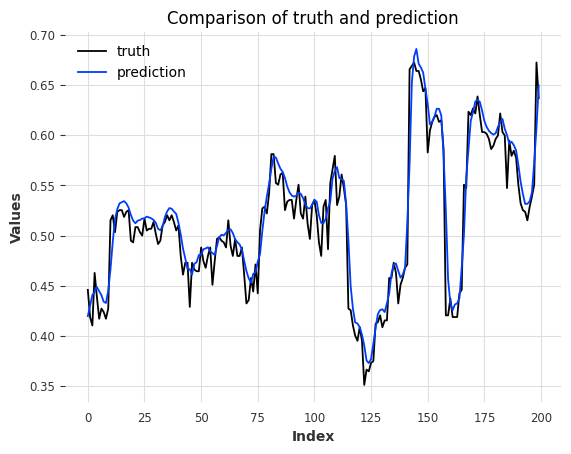

In [213]:
# Plot both DataFrames on the same plot
plt.plot(y_test[:, 2].squeeze()[start:start + width], label='truth')
plt.plot(df_copy['mean'][start:start + width], label='prediction')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of truth and prediction')
plt.legend()

# Show the plot
plt.show()